Introduction
--------
In this notebook I convert my curated CBIS-DDSM calcification table into a YOLO-style object-detection dataset, visually audit the generated labels, write a minimal dataset YAML, and launch a baseline YOLOv8 training run. I keep the process deterministic and auditable so I can iterate on model capacity and augmentation later without re-engineering the data path.

Workflow
- environment setup and imports
- dataset configuration and folder scaffold for YOLO
- box synthesis from precomputed cropped ROIs via template matching
- quick visualization loop to QA labels
- dataset YAML materialization
- YOLOv8 training with explicit hyperparameters

Assumptions
- `calc_preprocessed_clean.csv` contains full-image paths and cropped ROI paths that are consistent on disk
- each cropped ROI truly originates from its corresponding full image
- I treat all detections as a single class (`lesion`) for this baseline

In [1]:
# === Environment Configuration ===
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # allow MKL/OpenMP coexistence to avoid import warnings on some setups

# === Core Libraries ===
import os
import cv2
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# === Ultralytics YOLO ===
from ultralytics import YOLO  # entrypoint for training/eval/inference

# === IMPORTS ===
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt

Configuration and directory scaffold
------------------------------------
I resolve the project root relative to the notebook, point to the source CSV with preprocessed calcification samples, and define the root folder where I will build the YOLO dataset layout. I then create the canonical `images/` and `labels/` subtrees that YOLO expects.

Notes
- I place images under `images/all` and labels under `labels/all` as a single pool in this baseline
- class mapping is implicit (single class id 0 → "lesion") and encoded in the label lines later

In [2]:
# === CONFIG ===
# Go one level up from notebooks/ folder to reach project root
PROJECT_DIR = Path().resolve().parent

# Paths
csv_path = PROJECT_DIR / "data" / "calc_preprocessed_clean.csv" 
yolo_base_path = PROJECT_DIR / "data" /"CBIS_YOLO_TRAIN_DATASET"                    


# === CREATE YOLO FOLDER STRUCTURE ===
def setup_yolo_directories(base_path):
    """
    Creates the directory structure for YOLO training:
    base_path/
        └── images/
              └── all/
        └── labels/
              └── all/
    """
    images_dir = os.path.join(base_path, "images", "all")
    labels_dir = os.path.join(base_path, "labels", "all")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    return images_dir, labels_dir

output_images_dir, output_labels_dir = setup_yolo_directories(yolo_base_path)



Helper functions
----------------
I synthesize bounding boxes from the provided cropped ROI images by locating each crop within its parent full image using normalized cross-correlation template matching. I then convert the pixel-space rectangle into YOLO’s relative format `(xc, yc, w, h)`.

Caveat
- template matching assumes the crop is an exact sub-image of the full image (same intensity scaling and no rotation); this is adequate for my curated crops


In [3]:
# === HELPER FUNCTIONS ===
def get_crop_bbox(full_img, crop_img):
    """
    Find where the cropped image matches the full image using template matching.
    Returns x1, y1, x2, y2 bounding box in pixel coordinates.
    """
    full_gray = cv2.cvtColor(full_img, cv2.COLOR_BGR2GRAY)
    crop_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(full_gray, crop_gray, cv2.TM_CCOEFF_NORMED)
    _, _, _, max_loc = cv2.minMaxLoc(result)  # location of best match (top-left)
    x1, y1 = max_loc
    h, w = crop_gray.shape
    return x1, y1, x1 + w, y1 + h

def to_yolo_format(x1, y1, x2, y2, img_w, img_h):
    """
    Converts bounding box coordinates to YOLO format.
    """
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height



Generate YOLO images and labels
-------------------------------
For each full image in the CSV I:
- copy the full image to `images/all/`
- iterate all cropped ROIs that belong to that image
- localize each crop in the full image via template matching
- append a YOLO label line `0 xc yc w h` (single-class baseline) to the corresponding `.txt` in `labels/all/`

I keep a running log of missing files or matching failures so I can trace and correct source issues quickly.


In [4]:
# === MAIN PROCESSING ===
df = pd.read_csv(csv_path)
grouped = df.groupby('image_path')

for image_path, group in tqdm(grouped, desc="Processing Full Images"):
    if not os.path.exists(image_path):
        print(f"[Warning] Full image not found: {image_path}")
        continue

    full_img = cv2.imread(image_path)
    if full_img is None:
        print(f"[Error] Failed to read full image: {image_path}")
        continue

    img_h, img_w = full_img.shape[:2]
    image_filename = os.path.basename(image_path)
    label_filename = os.path.splitext(image_filename)[0] + ".txt"

    # Save full image to YOLO image directory
    output_img_path = os.path.join(output_images_dir, image_filename)
    cv2.imwrite(output_img_path, full_img)

    annotations = []

    for _, row in group.iterrows():
        cropped_path = row["cropped_image_path"]

        if not os.path.exists(cropped_path):
            print(f"[Warning] Cropped image not found: {cropped_path}")
            continue

        cropped_img = cv2.imread(cropped_path)
        if cropped_img is None:
            print(f"[Error] Failed to read cropped image: {cropped_path}")
            continue

        try:
            x1, y1, x2, y2 = get_crop_bbox(full_img, cropped_img)
            x_center, y_center, w, h = to_yolo_format(x1, y1, x2, y2, img_w, img_h)
            annotations.append(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")
        except Exception as e:
            print(f"[Error] Failed to match crop for {cropped_path}: {e}")

    if annotations:
        label_path = os.path.join(output_labels_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write("\n".join(annotations))

Processing Full Images: 100%|██████████| 1511/1511 [11:36<00:00,  2.17it/s]


Label visualization (QA)
------------------------
I render each image with its YOLO boxes to visually verify that the synthesized annotations actually sit on the lesions. The loop pauses per image so I can skim quickly and quit with `q` if needed.

What I look for
- boxes tightly covering the ROI
- no wild off-image coordinates (clamped in code)
- reasonable behavior when multiple crops map to the same full image

Images dir exists: True
Labels dir exists: True


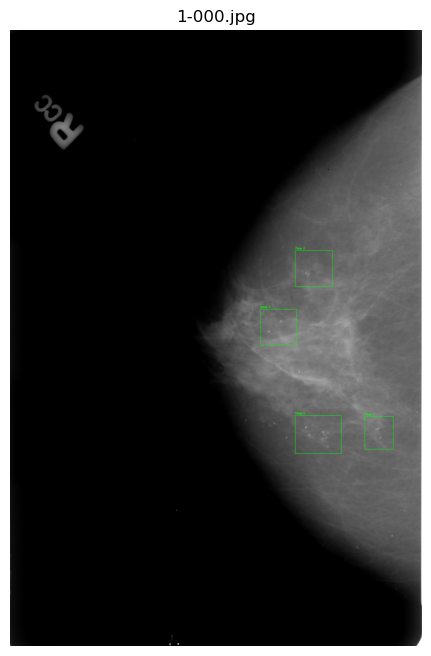

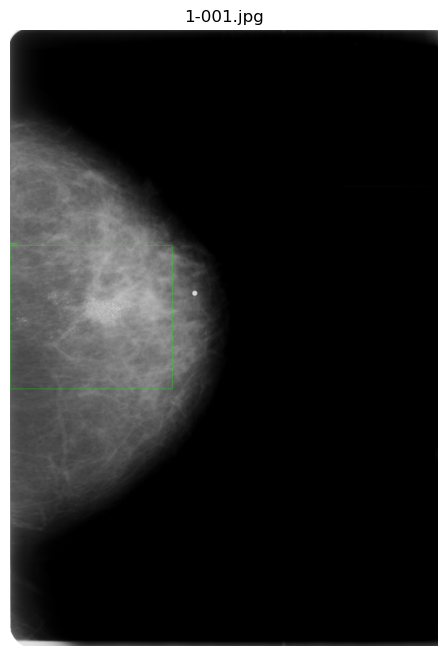

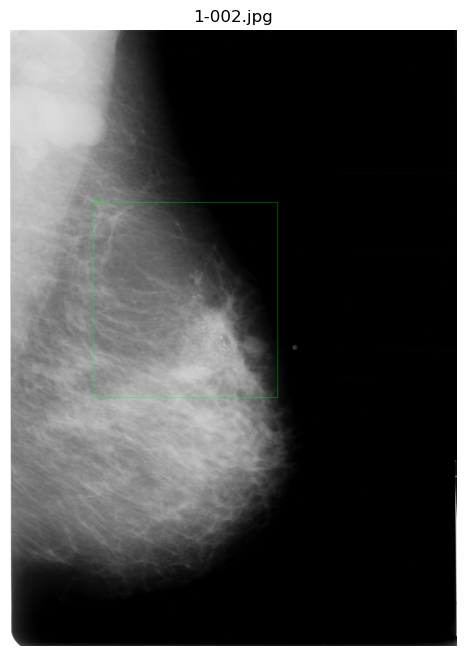

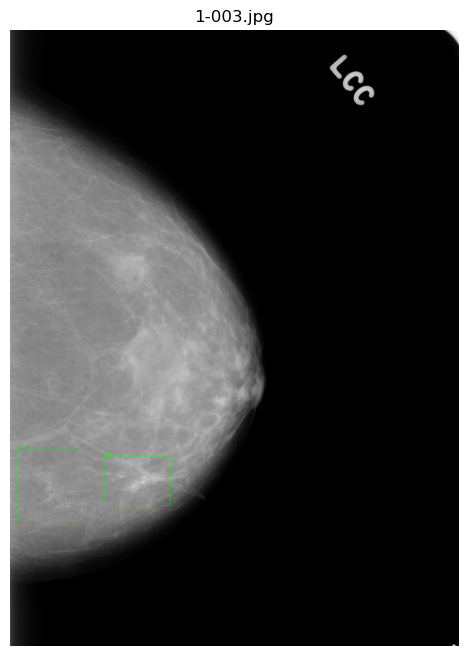

In [5]:
# === CONFIG ===
PROJECT_DIR = Path().resolve().parent

dataset_dir = PROJECT_DIR / "data" / "CBIS_YOLO_TRAIN_DATASET"
images_dir  = dataset_dir / "images" / "all"
labels_dir  = dataset_dir / "labels" / "all"

print("Images dir exists:", images_dir.exists())
print("Labels dir exists:", labels_dir.exists())

# === VISUALIZATION FUNCTION ===
def draw_yolo_bboxes(image_path: Path, label_path: Path):
    """Draw YOLO-format boxes (class xc yc w h in relative coords) on an image."""
    # OpenCV needs a string path
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"[Error] Could not read image: {image_path}")
        return

    img_h, img_w = image.shape[:2]

    if not label_path.exists():
        print(f"[Warning] No label file for: {image_path.name}")
    else:
        try:
            with open(label_path, "r", encoding="utf-8") as f:
                lines = [ln.strip() for ln in f if ln.strip()]
        except Exception as e:
            print(f"[Warning] Failed to read label file {label_path}: {e}")
            lines = []

        for line in lines:
            parts = line.split()
            if len(parts) != 5:
                print(f"[Warning] Skipping invalid line in {label_path.name}: {line}")
                continue

            try:
                cls_id, x_center, y_center, width, height = map(float, parts)
            except ValueError:
                print(f"[Warning] Non-numeric values in {label_path.name}: {line}")
                continue

            # Convert YOLO (relative) -> pixel coords
            x_center *= img_w
            y_center *= img_h
            width    *= img_w
            height   *= img_h

            x1 = int(x_center - width  / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width  / 2)
            y2 = int(y_center + height / 2)

            # Clamp to image bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w - 1, x2), min(img_h - 1, y2)

            # Draw
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"Class {int(cls_id)}", (x1, max(0, y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(image_path.name)
    plt.show()

# === LOOP OVER IMAGES ===
# Accept common extensions
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
image_files = sorted([p for p in images_dir.iterdir() if p.suffix.lower() in exts],
                     key=lambda p: p.name.lower())

if not image_files:
    print("[Info] No images found. Check images_dir path or file extensions.")

for img_path in image_files:
    lbl_path = labels_dir / (img_path.stem + ".txt")
    draw_yolo_bboxes(img_path, lbl_path)

    user_input = input("Press Enter for next image, or 'q' to quit: ").strip().lower()
    if user_input == 'q':
        break

Dataset YAML
------------
I write a minimal YOLO dataset configuration that points to the dataset root and declares a single class. For this baseline I reference the same `images` directory for both train and val. In later experiments I will split into explicit `images/train` and `images/val` subfolders and update the YAML accordingly.


In [6]:
yaml_path = PROJECT_DIR / "data" / "cbis.yaml"

# sanity checks (optional)
print("images dir exists:", (dataset_dir / "images").exists())
print("labels dir exists:", (dataset_dir / "labels").exists())

yaml_content = f"""\
# YOLO dataset config
path: {dataset_dir.as_posix()}   # absolute path to dataset root
train: images                    # (relative to 'path')
val: images                      # you can point to a separate val folder later

nc: 1
names: ['lesion']
"""

yaml_path.write_text(yaml_content, encoding="utf-8")
print("Wrote:", yaml_path)
print(yaml_content)


images dir exists: True
labels dir exists: True
Wrote: C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\data\cbis.yaml
# YOLO dataset config
path: C:/Users/PC/Desktop/final project/CBIS-DDSM/calc/YOLO model/data/CBIS_YOLO_TRAIN_DATASET   # absolute path to dataset root
train: images                    # (relative to 'path')
val: images                      # you can point to a separate val folder later

nc: 1
names: ['lesion']



Train a baseline YOLOv8 model
-----------------------------
I set a few explicit training hyperparameters and launch finetuning from the `yolov8s.pt` checkpoint. I keep the configuration readable and reproducible:
- epochs, image size, batch size, optimizer and learning rate
- early stopping patience and warmup
- output project/name and a fixed seed for determinism

The goal here is to establish a traceable baseline before exploring capacity, augmentation, or loss variations.

In [7]:
# Prevent memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

model = YOLO("yolov8s.pt")  # Lightweight model with good performance

model.train(
    data=str(yaml_path),
    epochs=150,
    imgsz=800,
    batch=4,
    device=0,
    lr0=0.001,
    optimizer="SGD",
    patience=20,
    workers=4,
    project=str(PROJECT_DIR / "CBIS_YOLO_PROJECT_output"),
    name="yolov8s_optimized",
    verbose=True,
    pretrained=True,
    close_mosaic=10,
    warmup_epochs=5,
    dropout=0.2,
    seed=42,
)

100%|██████████| 21.5M/21.5M [00:06<00:00, 3.27MB/s]


New https://pypi.org/project/ultralytics/8.3.202 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.171  Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\data\cbis.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

c:\Users\PC\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(
100%|██████████| 5.35M/5.35M [00:01<00:00, 3.21MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 248.180.3 MB/s, size: 1879.1 KB)


train: Scanning C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\data\CBIS_YOLO_TRAIN_DATASET\labels\all... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 535.97it/s]

train: New cache created: C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\data\CBIS_YOLO_TRAIN_DATASET\labels\all.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 1628.4144.7 MB/s, size: 1883.3 KB)


val: Scanning C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\data\CBIS_YOLO_TRAIN_DATASET\labels\all.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]


Plotting labels to C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized2\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 4 dataloader workers
Logging results to C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       1.5G      3.355      31.62      2.639         11        800: 100%|██████████| 75/75 [00:08<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00,  9.69it/s]


                   all        300        383    0.00546    0.00522   0.000516   0.000169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.66G      3.194      6.164      2.617         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.09it/s]


                   all        300        383   0.000945      0.222   0.000786   0.000236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.66G      3.181      4.729      2.561          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]


                   all        300        383    0.00111      0.243   0.000784   0.000212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.68G       3.29      4.332      2.607         12        800: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]


                   all        300        383    0.00106      0.149   0.000787   0.000253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.68G      3.022      4.099      2.431         17        800: 100%|██████████| 75/75 [00:06<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.03it/s]


                   all        300        383    0.00206      0.285    0.00402    0.00101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.68G      3.101       3.95      2.448         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]


                   all        300        383     0.0471     0.0157       0.01    0.00247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.68G      2.942      3.931      2.356          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.52it/s]


                   all        300        383     0.0924     0.0311     0.0175      0.005

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.68G      2.856      3.775       2.22         14        800: 100%|██████████| 75/75 [00:06<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.17it/s]


                   all        300        383     0.0806     0.0548     0.0181    0.00559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.68G      2.826      3.707      2.215          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.36it/s]


                   all        300        383     0.0837     0.0392     0.0238    0.00756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.68G      2.794      3.624      2.137         13        800: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.59it/s]


                   all        300        383      0.138     0.0444     0.0331     0.0097

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.68G      2.667      3.507      2.075          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]


                   all        300        383     0.0979      0.116     0.0334     0.0121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.68G      2.653      3.577      2.136          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.62it/s]


                   all        300        383      0.138     0.0888     0.0424     0.0152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.68G      2.637      3.455      2.085          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.50it/s]


                   all        300        383      0.129      0.047     0.0416     0.0152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.68G      2.543      3.447      2.055          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.48it/s]


                   all        300        383      0.104      0.125     0.0443     0.0155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.71G      2.453      3.365      1.987         12        800: 100%|██████████| 75/75 [00:07<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.35it/s]


                   all        300        383      0.117      0.117     0.0501     0.0172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.71G       2.44      3.364      1.995          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]


                   all        300        383      0.134      0.133     0.0647      0.021

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.71G      2.493      3.214       1.96          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.45it/s]


                   all        300        383      0.139      0.118     0.0661     0.0231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.71G      2.414      3.355      1.952         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.28it/s]


                   all        300        383      0.152      0.164     0.0682     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.71G      2.467      3.267      1.931         13        800: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.23it/s]


                   all        300        383      0.147       0.17     0.0673     0.0258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.71G      2.445      3.282       1.96          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.17it/s]


                   all        300        383      0.194      0.135      0.085     0.0333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.71G      2.435      3.205       1.94          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.22it/s]


                   all        300        383      0.168      0.156     0.0834      0.031

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.71G      2.269       3.12       1.86          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]


                   all        300        383      0.184      0.175      0.103     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.71G       2.32      3.177      1.899          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.20it/s]


                   all        300        383      0.216      0.144      0.101     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.71G      2.365      3.158      1.872         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.98it/s]


                   all        300        383      0.184      0.159      0.102     0.0395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.71G      2.273      3.083      1.811         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]


                   all        300        383      0.192      0.204      0.115     0.0465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.71G      2.333      3.075      1.831          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.47it/s]


                   all        300        383      0.197      0.217       0.13     0.0562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.71G      2.248      3.015      1.804         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]


                   all        300        383      0.239      0.188      0.138     0.0574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.71G      2.288      3.045      1.812          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.48it/s]


                   all        300        383      0.168      0.214      0.109     0.0476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.71G      2.249      3.023      1.795         14        800: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.62it/s]


                   all        300        383      0.242      0.183      0.152     0.0631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.71G      2.209      2.951      1.784         22        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.07it/s]


                   all        300        383      0.229      0.185      0.135     0.0565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.73G      2.179       2.81      1.686          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]


                   all        300        383       0.21      0.214      0.138      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.76G      2.283      3.035      1.771         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.27it/s]


                   all        300        383      0.259       0.23      0.146     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.76G       2.21      2.874      1.742         12        800: 100%|██████████| 75/75 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.53it/s]


                   all        300        383      0.275      0.248      0.174     0.0726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.76G      2.167      2.915      1.747          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]


                   all        300        383      0.308      0.221      0.189     0.0842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.76G      2.251      2.938      1.814         12        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.12it/s]


                   all        300        383      0.303      0.219      0.199     0.0921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.76G      2.152      2.847      1.731          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]


                   all        300        383      0.383      0.217      0.211     0.0973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.76G      2.148      2.841      1.716         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.51it/s]

                   all        300        383      0.349      0.214      0.212     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.76G       2.04      2.748       1.66          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.37it/s]


                   all        300        383      0.317      0.243      0.216      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.76G      2.108      2.683      1.718          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.50it/s]


                   all        300        383      0.372      0.245      0.239       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.76G      2.143      2.729      1.723         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        383      0.348      0.235      0.216      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.76G      2.164      2.674      1.723          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.45it/s]


                   all        300        383      0.337      0.251      0.248       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.76G      2.059      2.649      1.675          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        383      0.346      0.274      0.236      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.76G       2.08      2.691      1.657          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.40it/s]


                   all        300        383      0.326      0.257      0.234      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.76G      2.018      2.565       1.62         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.51it/s]

                   all        300        383      0.378      0.269      0.248      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.76G      2.077      2.626      1.652          3        800: 100%|██████████| 75/75 [00:07<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        383      0.355      0.245      0.248      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.76G      2.065      2.505      1.637          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.28it/s]

                   all        300        383      0.364       0.29      0.259      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.76G      2.013      2.593      1.634          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.38it/s]


                   all        300        383      0.383      0.295      0.296      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.76G      2.014       2.55      1.648         17        800: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.23it/s]

                   all        300        383      0.462      0.251      0.279       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.76G      2.052      2.557      1.658          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        383      0.401      0.261      0.294      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.76G      2.098      2.663      1.684          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.40it/s]

                   all        300        383      0.479      0.276      0.328      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.76G       2.04      2.499      1.642         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.29it/s]

                   all        300        383      0.478      0.321      0.343       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.76G       1.99      2.426      1.621          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.26it/s]

                   all        300        383      0.461      0.326      0.319      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.76G      1.983      2.384      1.614          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]

                   all        300        383      0.444      0.307      0.303      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.76G      1.965      2.424      1.597         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.16it/s]

                   all        300        383      0.426      0.337      0.331      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.76G      1.933      2.315      1.581          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.88it/s]


                   all        300        383      0.456      0.347      0.346      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.76G      1.965      2.344      1.576         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]

                   all        300        383      0.416      0.347      0.314      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.76G      1.838      2.327      1.554          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.54it/s]

                   all        300        383      0.387      0.371      0.339      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.76G      1.959      2.503       1.61         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.44it/s]

                   all        300        383      0.533      0.334      0.393      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.76G      1.885      2.294      1.581          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        383      0.492      0.367      0.395      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.76G      1.922       2.33      1.562          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.83it/s]

                   all        300        383      0.488      0.352      0.375      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.76G      1.859      2.232       1.51         12        800: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.56it/s]

                   all        300        383      0.496      0.349      0.411      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.76G      1.875      2.307      1.523         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        383      0.481      0.386      0.427      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.76G      1.795      2.173      1.509          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.44it/s]

                   all        300        383      0.404      0.379      0.358      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.76G      1.886      2.283      1.569          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.33it/s]

                   all        300        383      0.512      0.376       0.43      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.76G      1.791      2.104      1.486          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]

                   all        300        383       0.55      0.373       0.43      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.76G      1.882      2.238      1.542          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        383      0.548      0.363      0.407      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.76G      1.843      2.223      1.525          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]


                   all        300        383      0.569       0.41      0.454      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.76G      1.853       2.19      1.538         13        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        383       0.58       0.41      0.474      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.76G      1.803      2.099      1.496         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.40it/s]

                   all        300        383      0.531      0.415      0.462       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.76G        1.8      2.134      1.519          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.22it/s]

                   all        300        383      0.584       0.42      0.494      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.76G      1.871      2.186      1.555          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        383      0.571      0.399      0.469      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.76G      1.802      2.034       1.45          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.60it/s]

                   all        300        383        0.6      0.368       0.45      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.76G       1.83      2.131       1.49         13        800: 100%|██████████| 75/75 [00:07<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.55it/s]

                   all        300        383      0.618      0.399      0.492      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      1.76G      1.907      2.163      1.507         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.38it/s]

                   all        300        383      0.554      0.453      0.507      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      1.76G      1.768      2.018      1.429          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.35it/s]

                   all        300        383      0.553      0.457      0.504      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      1.76G      1.772      1.964      1.464          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.60it/s]

                   all        300        383      0.598      0.455      0.531      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      1.76G      1.808      2.079       1.46          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.50it/s]

                   all        300        383      0.549      0.439      0.466      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      1.76G      1.779       1.96      1.476          3        800: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.21it/s]

                   all        300        383      0.649       0.46      0.552       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      1.76G      1.721       2.01      1.457          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.40it/s]

                   all        300        383      0.685      0.457       0.54      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      1.76G      1.763      1.981      1.452          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.36it/s]

                   all        300        383       0.57      0.384      0.439      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      1.76G      1.716       1.87      1.438         15        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.41it/s]

                   all        300        383      0.695      0.483      0.587      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      1.76G      1.687      1.801      1.414          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        383      0.668      0.475      0.572       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      1.76G      1.771      1.961      1.501          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.64it/s]

                   all        300        383      0.644       0.53      0.604      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      1.76G      1.706      1.875      1.389         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.33it/s]

                   all        300        383      0.636      0.488      0.573      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      1.76G      1.708      1.899      1.432          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.50it/s]

                   all        300        383      0.754      0.486      0.594      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      1.76G      1.716      1.834      1.436         10        800: 100%|██████████| 75/75 [00:07<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.19it/s]

                   all        300        383      0.731      0.503      0.621      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      1.76G      1.635      1.827      1.419          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.44it/s]

                   all        300        383       0.68      0.501      0.594      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      1.76G      1.756      1.831      1.391          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.41it/s]

                   all        300        383      0.613      0.525      0.588      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      1.78G      1.634      1.756      1.398         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        383       0.76      0.475      0.608      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      1.78G      1.714       1.78        1.4         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]

                   all        300        383      0.627      0.533      0.595      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      1.78G      1.702      1.784      1.426          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        383      0.759      0.522      0.627      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      1.78G      1.719      1.875      1.454         12        800: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.25it/s]

                   all        300        383      0.684      0.548      0.636      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      1.78G       1.63      1.658      1.367          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.61it/s]

                   all        300        383      0.716      0.514      0.608       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      1.78G       1.65       1.77       1.39          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.39it/s]

                   all        300        383      0.784      0.503      0.633      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      1.78G      1.694      1.814      1.417          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.55it/s]

                   all        300        383      0.727      0.582      0.679       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      1.78G      1.699      1.786      1.404         12        800: 100%|██████████| 75/75 [00:06<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.27it/s]

                   all        300        383       0.75      0.582      0.691       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      1.78G      1.645      1.739      1.343          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

                   all        300        383      0.712       0.56      0.649      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      1.78G      1.604      1.664       1.33          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.52it/s]

                   all        300        383      0.752      0.563      0.668      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      1.78G      1.512      1.569      1.326         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.47it/s]

                   all        300        383       0.74      0.603      0.697      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      1.78G      1.582      1.617      1.323          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        383      0.719      0.621      0.711      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      1.78G      1.602      1.676      1.327          3        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        383      0.724      0.582       0.68       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      1.78G      1.641      1.675      1.383          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.05it/s]

                   all        300        383      0.772      0.567       0.68       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      1.78G      1.598       1.66      1.349          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.51it/s]

                   all        300        383      0.715      0.603        0.7      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150       1.8G      1.656      1.681      1.374         14        800: 100%|██████████| 75/75 [00:06<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.14it/s]

                   all        300        383      0.754      0.593       0.71      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150       1.8G      1.614      1.677      1.348         10        800: 100%|██████████| 75/75 [00:06<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.53it/s]

                   all        300        383      0.765      0.637      0.731      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       1.8G      1.636      1.624      1.367          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        383       0.75      0.603      0.704      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150       1.8G      1.581      1.572      1.327          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.28it/s]

                   all        300        383      0.736      0.611      0.705      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150       1.8G      1.598      1.602      1.321          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.39it/s]

                   all        300        383       0.66      0.597      0.666      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150       1.8G      1.586      1.646      1.352          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.59it/s]

                   all        300        383      0.793      0.589      0.707      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      1.81G      1.541      1.475      1.327          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.31it/s]

                   all        300        383      0.801      0.637       0.75       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      1.81G       1.54      1.574      1.348          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.48it/s]

                   all        300        383      0.825       0.58      0.731      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      1.81G      1.587      1.622      1.327          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.38it/s]

                   all        300        383      0.829      0.614      0.737      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      1.81G      1.519      1.555      1.321         15        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.64it/s]

                   all        300        383      0.766      0.655      0.736      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      1.81G      1.534       1.49      1.304         12        800: 100%|██████████| 75/75 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.56it/s]

                   all        300        383       0.79       0.63      0.738      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      1.81G       1.53      1.494      1.309         11        800: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.38it/s]

                   all        300        383      0.781      0.624      0.732      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      1.81G      1.519      1.524      1.316          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        383      0.841      0.622      0.765      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      1.83G      1.602      1.577      1.338          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.30it/s]

                   all        300        383      0.817      0.634      0.753      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      1.83G      1.516      1.518      1.311          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.40it/s]

                   all        300        383      0.798      0.628      0.732      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      1.83G      1.535      1.546      1.308          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.95it/s]

                   all        300        383      0.872      0.601      0.758      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      1.83G      1.569      1.556      1.317          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.39it/s]

                   all        300        383      0.874      0.631       0.77       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      1.83G      1.527      1.517      1.318          8        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.28it/s]

                   all        300        383      0.847      0.648       0.78      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      1.83G      1.436      1.383      1.252          9        800: 100%|██████████| 75/75 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        383      0.846      0.645      0.771      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      1.83G      1.528      1.516      1.292         14        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

                   all        300        383      0.805      0.629      0.747      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       1.9G      1.497      1.478      1.294         16        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.43it/s]

                   all        300        383      0.828      0.666      0.778      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       1.9G      1.498      1.436        1.3          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.57it/s]

                   all        300        383      0.826      0.645      0.769      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       1.9G      1.506       1.43      1.281         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.38it/s]

                   all        300        383      0.834      0.627      0.757      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       1.9G      1.519      1.473      1.294         14        800: 100%|██████████| 75/75 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        383      0.771      0.687      0.773      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150       1.9G      1.476      1.334      1.265         13        800: 100%|██████████| 75/75 [00:07<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.47it/s]

                   all        300        383      0.881      0.632      0.779      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       1.9G      1.465      1.405       1.27          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.36it/s]

                   all        300        383      0.835      0.666       0.78        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      1.92G       1.49      1.448      1.298         11        800: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 11.41it/s]

                   all        300        383      0.802      0.717      0.792       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      1.92G      1.511      1.485       1.31          6        800: 100%|██████████| 75/75 [00:07<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.36it/s]

                   all        300        383      0.794      0.684      0.769      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      1.92G       1.47      1.399      1.261          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.37it/s]

                   all        300        383      0.813      0.642      0.743      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      1.92G      1.533      1.481      1.291          8        800: 100%|██████████| 75/75 [00:07<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.54it/s]

                   all        300        383      0.821      0.668      0.775      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      1.92G      1.525      1.374      1.299          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.11it/s]

                   all        300        383      0.844      0.671      0.798      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      1.92G      1.526      1.417      1.276          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.33it/s]

                   all        300        383      0.868      0.671      0.799      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      1.92G      1.503      1.399      1.283          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.24it/s]

                   all        300        383       0.85      0.684      0.798      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      1.92G      1.441      1.362      1.222          7        800: 100%|██████████| 75/75 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.45it/s]

                   all        300        383      0.851      0.671      0.794      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      1.92G       1.56      1.509      1.286          9        800: 100%|██████████| 75/75 [00:07<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.58it/s]

                   all        300        383      0.856      0.682      0.793      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      1.92G      1.462       1.33      1.261          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.32it/s]

                   all        300        383       0.86      0.661       0.79      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      1.92G      1.496      1.416      1.262          7        800: 100%|██████████| 75/75 [00:07<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.52it/s]

                   all        300        383      0.825      0.708      0.806      0.522


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      1.92G      1.629      1.557      1.344          4        800: 100%|██████████| 75/75 [00:07<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.37it/s]

                   all        300        383      0.748      0.689      0.764       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      1.92G      1.554      1.459      1.324          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.37it/s]

                   all        300        383      0.773      0.632       0.75      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      1.92G      1.574      1.529      1.341          5        800: 100%|██████████| 75/75 [00:07<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.17it/s]

                   all        300        383      0.742      0.676      0.756      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      1.92G      1.639       1.53      1.356          6        800: 100%|██████████| 75/75 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.39it/s]


                   all        300        383       0.75      0.645      0.746       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      1.92G      1.524      1.433      1.315          4        800: 100%|██████████| 75/75 [00:06<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

                   all        300        383       0.81      0.671      0.778      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      1.92G      1.548      1.428      1.337          7        800: 100%|██████████| 75/75 [00:06<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.81it/s]

                   all        300        383       0.85      0.655      0.784      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      1.92G        1.5      1.393      1.279          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.74it/s]

                   all        300        383       0.84      0.674      0.786        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      1.92G      1.426      1.346       1.27          4        800: 100%|██████████| 75/75 [00:06<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:03<00:00, 12.50it/s]

                   all        300        383      0.812      0.702      0.788      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      1.92G       1.45      1.364      1.267          4        800: 100%|██████████| 75/75 [00:06<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.72it/s]

                   all        300        383      0.822      0.684      0.787      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      1.92G      1.533      1.356      1.313          5        800: 100%|██████████| 75/75 [00:06<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 12.67it/s]

                   all        300        383      0.802      0.687      0.789      0.499



150 epochs completed in 0.451 hours.
Optimizer stripped from C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized2\weights\last.pt, 22.5MB
Optimizer stripped from C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized2\weights\best.pt, 22.5MB

Validating C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized2\weights\best.pt...
Ultralytics 8.3.171  Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:02<00:00, 13.60it/s]


                   all        300        383      0.831      0.705      0.804      0.522
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\YOLO model\CBIS_YOLO_PROJECT_output\yolov8s_optimized2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024F813C7D20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480